## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [3]:
import os
current_dir = os.getcwd()
diabetes_df = pd.read_csv(current_dir+'//diabetes.csv')

In [4]:
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
163,2,100,64,23,0,29.7,0.368,21,0
2,8,183,64,0,0,23.3,0.672,32,1
764,2,122,70,27,0,36.8,0.340,27,0
706,10,115,0,0,0,0.0,0.261,30,1
664,6,115,60,39,0,33.7,0.245,40,1


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["Outcome"].values

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.760
roc-auc is 0.831


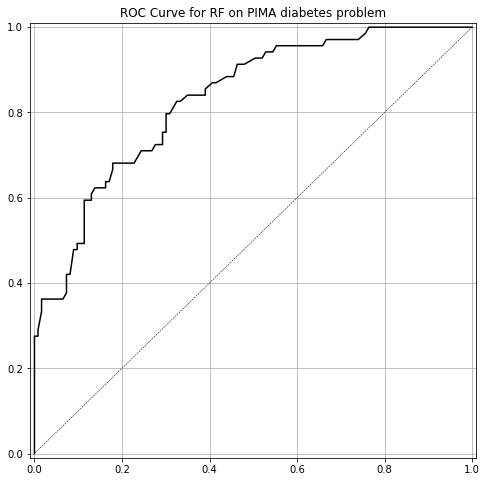

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [12]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [14]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Instructions for updating:
Use tf.cast instead.
Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 591us/step - loss: 0.7803 - acc: 0.4913 - val_loss: 0.8193 - val_acc: 0.4635
Epoch 2/200
576/576 [==============================] - 0s 31us/step - loss: 0.7625 - acc: 0.5208 - val_loss: 0.8035 - val_acc: 0.4740
Epoch 3/200
576/576 [==============================] - 0s 33us/step - loss: 0.7463 - acc: 0.5556 - val_loss: 0.7891 - val_acc: 0.5208
Epoch 4/200
576/576 [==============================] - 0s 40us/step - loss: 0.7316 - acc: 0.5781 - val_loss: 0.7759 - val_acc: 0.5469
Epoch 5/200
576/576 [==============================] - 0s 35us/step - loss: 0.7181 - acc: 0.6163 - val_loss: 0.7638 - val_acc: 0.5677
Epoch 6/200
576/576 [==============================] - 0s 31us/step - loss: 0.7058 - acc: 0.6372 - val_loss: 0.7527 - val_acc: 0.5625
Epoch 7/200
576/576 [==============================] - 0s 31us/step - loss: 0.6946 - acc: 0.6424 - va

576/576 [==============================] - 0s 33us/step - loss: 0.4804 - acc: 0.7726 - val_loss: 0.5423 - val_acc: 0.7188
Epoch 120/200
576/576 [==============================] - 0s 36us/step - loss: 0.4800 - acc: 0.7726 - val_loss: 0.5420 - val_acc: 0.7188
Epoch 121/200
576/576 [==============================] - 0s 47us/step - loss: 0.4796 - acc: 0.7726 - val_loss: 0.5417 - val_acc: 0.7188
Epoch 122/200
576/576 [==============================] - 0s 38us/step - loss: 0.4793 - acc: 0.7726 - val_loss: 0.5414 - val_acc: 0.7188
Epoch 123/200
576/576 [==============================] - 0s 31us/step - loss: 0.4789 - acc: 0.7726 - val_loss: 0.5411 - val_acc: 0.7188
Epoch 124/200
576/576 [==============================] - 0s 29us/step - loss: 0.4785 - acc: 0.7726 - val_loss: 0.5408 - val_acc: 0.7188
Epoch 125/200
576/576 [==============================] - 0s 29us/step - loss: 0.4781 - acc: 0.7726 - val_loss: 0.5405 - val_acc: 0.7188
Epoch 126/200
576/576 [==============================] - 0s 28

In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [17]:
y_pred_prob_nn_1[:10]

array([[0.53114927],
       [0.64171726],
       [0.2958378 ],
       [0.30220217],
       [0.14479771],
       [0.62375987],
       [0.0551585 ],
       [0.24550319],
       [0.8385385 ],
       [0.23618695]], dtype=float32)

accuracy is 0.729
roc-auc is 0.788


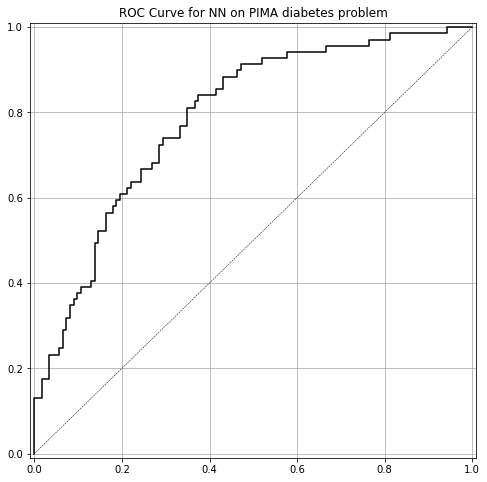

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

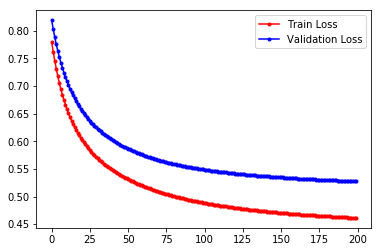

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4611 - acc: 0.7760 - val_loss: 0.5275 - val_acc: 0.7292
Epoch 2/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4610 - acc: 0.7760 - val_loss: 0.5274 - val_acc: 0.7292
Epoch 3/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4609 - acc: 0.7760 - val_loss: 0.5273 - val_acc: 0.7292
Epoch 4/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4608 - acc: 0.7760 - val_loss: 0.5272 - val_acc: 0.7292
Epoch 5/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4606 - acc: 0.7760 - val_loss: 0.5271 - val_acc: 0.7396
Epoch 6/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4605 - acc: 0.7760 - val_loss: 0.5270 - val_acc: 0.7396
Epoch 7/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4603 - acc: 0.7760 - val_loss: 0.5269 - val_acc: 0.7396
Epoch 8/1

Epoch 61/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4544 - acc: 0.7708 - val_loss: 0.5232 - val_acc: 0.7448
Epoch 62/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4543 - acc: 0.7708 - val_loss: 0.5232 - val_acc: 0.7448
Epoch 63/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4542 - acc: 0.7708 - val_loss: 0.5231 - val_acc: 0.7448
Epoch 64/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4541 - acc: 0.7708 - val_loss: 0.5231 - val_acc: 0.7448
Epoch 65/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4540 - acc: 0.7708 - val_loss: 0.5230 - val_acc: 0.7448
Epoch 66/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4539 - acc: 0.7708 - val_loss: 0.5230 - val_acc: 0.7448
Epoch 67/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4538 - acc: 0.7708 - val_loss: 0.5229 - val_acc: 0.7448
Epoch 68/1000
576/576 [=========================

576/576 [==============================] - 0s 31us/step - loss: 0.4493 - acc: 0.7743 - val_loss: 0.5212 - val_acc: 0.7448
Epoch 122/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4492 - acc: 0.7743 - val_loss: 0.5211 - val_acc: 0.7448
Epoch 123/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4491 - acc: 0.7743 - val_loss: 0.5211 - val_acc: 0.7448
Epoch 124/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4490 - acc: 0.7743 - val_loss: 0.5210 - val_acc: 0.7448
Epoch 125/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4489 - acc: 0.7743 - val_loss: 0.5210 - val_acc: 0.7448
Epoch 126/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4489 - acc: 0.7743 - val_loss: 0.5210 - val_acc: 0.7448
Epoch 127/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4488 - acc: 0.7743 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 128/1000
576/576 [==============================] 

Epoch 181/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4456 - acc: 0.7760 - val_loss: 0.5193 - val_acc: 0.7500
Epoch 182/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4455 - acc: 0.7743 - val_loss: 0.5192 - val_acc: 0.7500
Epoch 183/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4455 - acc: 0.7760 - val_loss: 0.5192 - val_acc: 0.7500
Epoch 184/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4454 - acc: 0.7743 - val_loss: 0.5192 - val_acc: 0.7500
Epoch 185/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4454 - acc: 0.7778 - val_loss: 0.5192 - val_acc: 0.7500
Epoch 186/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4453 - acc: 0.7760 - val_loss: 0.5191 - val_acc: 0.7500
Epoch 187/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4453 - acc: 0.7778 - val_loss: 0.5191 - val_acc: 0.7500
Epoch 188/1000
576/576 [=================

Epoch 241/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4427 - acc: 0.7812 - val_loss: 0.5177 - val_acc: 0.7604
Epoch 242/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4427 - acc: 0.7812 - val_loss: 0.5177 - val_acc: 0.7604
Epoch 243/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4426 - acc: 0.7830 - val_loss: 0.5177 - val_acc: 0.7604
Epoch 244/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4425 - acc: 0.7830 - val_loss: 0.5177 - val_acc: 0.7604
Epoch 245/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4425 - acc: 0.7812 - val_loss: 0.5177 - val_acc: 0.7604
Epoch 246/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4425 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7604
Epoch 247/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4424 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7604
Epoch 248/1000
576/576 [=================

Epoch 301/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4405 - acc: 0.7812 - val_loss: 0.5162 - val_acc: 0.7604
Epoch 302/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4404 - acc: 0.7812 - val_loss: 0.5162 - val_acc: 0.7604
Epoch 303/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4404 - acc: 0.7812 - val_loss: 0.5162 - val_acc: 0.7604
Epoch 304/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4403 - acc: 0.7812 - val_loss: 0.5161 - val_acc: 0.7604
Epoch 305/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4403 - acc: 0.7812 - val_loss: 0.5161 - val_acc: 0.7604
Epoch 306/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4403 - acc: 0.7812 - val_loss: 0.5161 - val_acc: 0.7604
Epoch 307/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4402 - acc: 0.7812 - val_loss: 0.5160 - val_acc: 0.7604
Epoch 308/1000
576/576 [=================

Epoch 361/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4384 - acc: 0.7778 - val_loss: 0.5147 - val_acc: 0.7448
Epoch 362/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4384 - acc: 0.7778 - val_loss: 0.5147 - val_acc: 0.7448
Epoch 363/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4383 - acc: 0.7778 - val_loss: 0.5147 - val_acc: 0.7448
Epoch 364/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4383 - acc: 0.7778 - val_loss: 0.5146 - val_acc: 0.7448
Epoch 365/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4383 - acc: 0.7778 - val_loss: 0.5146 - val_acc: 0.7448
Epoch 366/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4382 - acc: 0.7778 - val_loss: 0.5146 - val_acc: 0.7448
Epoch 367/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4382 - acc: 0.7778 - val_loss: 0.5146 - val_acc: 0.7448
Epoch 368/1000
576/576 [=================

Epoch 421/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4363 - acc: 0.7778 - val_loss: 0.5134 - val_acc: 0.7500
Epoch 422/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4363 - acc: 0.7778 - val_loss: 0.5134 - val_acc: 0.7500
Epoch 423/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4363 - acc: 0.7778 - val_loss: 0.5134 - val_acc: 0.7500
Epoch 424/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4363 - acc: 0.7778 - val_loss: 0.5134 - val_acc: 0.7500
Epoch 425/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4362 - acc: 0.7778 - val_loss: 0.5134 - val_acc: 0.7500
Epoch 426/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4362 - acc: 0.7778 - val_loss: 0.5134 - val_acc: 0.7500
Epoch 427/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4362 - acc: 0.7778 - val_loss: 0.5133 - val_acc: 0.7500
Epoch 428/1000
576/576 [=================

Epoch 481/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4344 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 482/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4343 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 483/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4343 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 484/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4343 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 485/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4342 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 486/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4342 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 487/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4342 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7448
Epoch 488/1000
576/576 [=================

Epoch 541/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4326 - acc: 0.7760 - val_loss: 0.5120 - val_acc: 0.7500
Epoch 542/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4326 - acc: 0.7760 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 543/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4326 - acc: 0.7760 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 544/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4325 - acc: 0.7760 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 545/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4325 - acc: 0.7760 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 546/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4324 - acc: 0.7760 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 547/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4324 - acc: 0.7760 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 548/1000
576/576 [=================

Epoch 601/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4310 - acc: 0.7760 - val_loss: 0.5112 - val_acc: 0.7500
Epoch 602/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4310 - acc: 0.7760 - val_loss: 0.5112 - val_acc: 0.7500
Epoch 603/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4309 - acc: 0.7760 - val_loss: 0.5112 - val_acc: 0.7500
Epoch 604/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4309 - acc: 0.7760 - val_loss: 0.5111 - val_acc: 0.7500
Epoch 605/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4309 - acc: 0.7760 - val_loss: 0.5111 - val_acc: 0.7500
Epoch 606/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4308 - acc: 0.7760 - val_loss: 0.5111 - val_acc: 0.7500
Epoch 607/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4308 - acc: 0.7760 - val_loss: 0.5111 - val_acc: 0.7500
Epoch 608/1000
576/576 [=================

Epoch 661/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4295 - acc: 0.7778 - val_loss: 0.5107 - val_acc: 0.7448
Epoch 662/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4295 - acc: 0.7778 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 663/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4295 - acc: 0.7795 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 664/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4295 - acc: 0.7778 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 665/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4295 - acc: 0.7795 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 666/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4294 - acc: 0.7778 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 667/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4294 - acc: 0.7795 - val_loss: 0.5107 - val_acc: 0.7500
Epoch 668/1000
576/576 [=================

Epoch 780/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4267 - acc: 0.7882 - val_loss: 0.5098 - val_acc: 0.7812
Epoch 781/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4266 - acc: 0.7882 - val_loss: 0.5098 - val_acc: 0.7812
Epoch 782/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4266 - acc: 0.7882 - val_loss: 0.5098 - val_acc: 0.7812
Epoch 783/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4266 - acc: 0.7865 - val_loss: 0.5097 - val_acc: 0.7812
Epoch 784/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4266 - acc: 0.7882 - val_loss: 0.5097 - val_acc: 0.7812
Epoch 785/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4265 - acc: 0.7865 - val_loss: 0.5097 - val_acc: 0.7812
Epoch 786/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4265 - acc: 0.7882 - val_loss: 0.5097 - val_acc: 0.7812
Epoch 787/1000
576/576 [=================

Epoch 899/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4239 - acc: 0.7917 - val_loss: 0.5092 - val_acc: 0.7812
Epoch 900/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4239 - acc: 0.7917 - val_loss: 0.5092 - val_acc: 0.7812
Epoch 901/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4239 - acc: 0.7917 - val_loss: 0.5092 - val_acc: 0.7812
Epoch 902/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4239 - acc: 0.7917 - val_loss: 0.5093 - val_acc: 0.7812
Epoch 903/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4238 - acc: 0.7917 - val_loss: 0.5093 - val_acc: 0.7812
Epoch 904/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4238 - acc: 0.7917 - val_loss: 0.5093 - val_acc: 0.7812
Epoch 905/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4238 - acc: 0.7917 - val_loss: 0.5093 - val_acc: 0.7812
Epoch 906/1000
576/576 [=================

Epoch 959/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4225 - acc: 0.7951 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 960/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4225 - acc: 0.7951 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 961/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4225 - acc: 0.7951 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 962/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4225 - acc: 0.7951 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 963/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4225 - acc: 0.7951 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 964/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4224 - acc: 0.7951 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 965/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4224 - acc: 0.7934 - val_loss: 0.5096 - val_acc: 0.7760
Epoch 966/1000
576/576 [=================

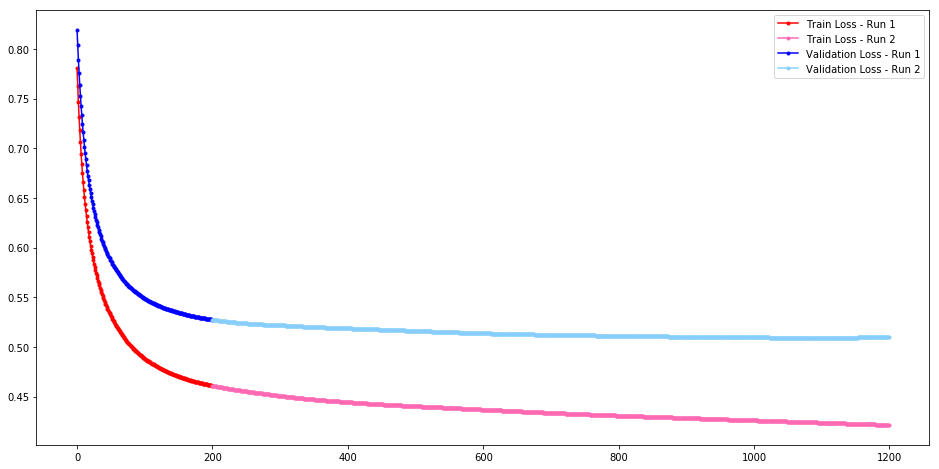

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [23]:
# Type your code here to with layer 1,2 having activation relu and layer 3 with activation sigmoid
model_2 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6,input_shape = (6,),activation='relu'),
    Dense(1, activation="sigmoid")
])


In [24]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500);

Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 0s 688us/step - loss: 0.7997 - acc: 0.3507 - val_loss: 0.7916 - val_acc: 0.3698
Epoch 2/1500
576/576 [==============================] - 0s 35us/step - loss: 0.7815 - acc: 0.3576 - val_loss: 0.7764 - val_acc: 0.3750
Epoch 3/1500
576/576 [==============================] - 0s 33us/step - loss: 0.7651 - acc: 0.3628 - val_loss: 0.7625 - val_acc: 0.3802
Epoch 4/1500
576/576 [==============================] - 0s 35us/step - loss: 0.7501 - acc: 0.3767 - val_loss: 0.7500 - val_acc: 0.3906
Epoch 5/1500
576/576 [==============================] - 0s 40us/step - loss: 0.7365 - acc: 0.4028 - val_loss: 0.7385 - val_acc: 0.4062
Epoch 6/1500
576/576 [==============================] - 0s 35us/step - loss: 0.7240 - acc: 0.4392 - val_loss: 0.7280 - val_acc: 0.4427
Epoch 7/1500
576/576 [==============================] - 0s 33us/step - loss: 0.7126 - acc: 0.4740 - val_loss: 0.7184 - val_acc: 0.4635
Epoch 8/

Epoch 61/1500
576/576 [==============================] - 0s 42us/step - loss: 0.5365 - acc: 0.7205 - val_loss: 0.5793 - val_acc: 0.7083
Epoch 62/1500
576/576 [==============================] - 0s 31us/step - loss: 0.5355 - acc: 0.7222 - val_loss: 0.5786 - val_acc: 0.7135
Epoch 63/1500
576/576 [==============================] - 0s 33us/step - loss: 0.5345 - acc: 0.7240 - val_loss: 0.5779 - val_acc: 0.7135
Epoch 64/1500
576/576 [==============================] - 0s 31us/step - loss: 0.5336 - acc: 0.7222 - val_loss: 0.5773 - val_acc: 0.7188
Epoch 65/1500
576/576 [==============================] - 0s 29us/step - loss: 0.5326 - acc: 0.7222 - val_loss: 0.5766 - val_acc: 0.7188
Epoch 66/1500
576/576 [==============================] - 0s 33us/step - loss: 0.5317 - acc: 0.7222 - val_loss: 0.5759 - val_acc: 0.7188
Epoch 67/1500
576/576 [==============================] - 0s 31us/step - loss: 0.5308 - acc: 0.7222 - val_loss: 0.5753 - val_acc: 0.7188
Epoch 68/1500
576/576 [=========================

Epoch 180/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4758 - acc: 0.7604 - val_loss: 0.5350 - val_acc: 0.7500
Epoch 181/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4756 - acc: 0.7587 - val_loss: 0.5348 - val_acc: 0.7500
Epoch 182/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4753 - acc: 0.7604 - val_loss: 0.5347 - val_acc: 0.7500
Epoch 183/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4750 - acc: 0.7604 - val_loss: 0.5346 - val_acc: 0.7500
Epoch 184/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4748 - acc: 0.7604 - val_loss: 0.5345 - val_acc: 0.7500
Epoch 185/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4746 - acc: 0.7639 - val_loss: 0.5344 - val_acc: 0.7500
Epoch 186/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4743 - acc: 0.7639 - val_loss: 0.5343 - val_acc: 0.7500
Epoch 187/1500
576/576 [=================

Epoch 240/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4637 - acc: 0.7760 - val_loss: 0.5294 - val_acc: 0.7552
Epoch 241/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4636 - acc: 0.7760 - val_loss: 0.5293 - val_acc: 0.7552
Epoch 242/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4634 - acc: 0.7743 - val_loss: 0.5292 - val_acc: 0.7552
Epoch 243/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4633 - acc: 0.7743 - val_loss: 0.5291 - val_acc: 0.7552
Epoch 244/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4631 - acc: 0.7743 - val_loss: 0.5291 - val_acc: 0.7552
Epoch 245/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4630 - acc: 0.7743 - val_loss: 0.5290 - val_acc: 0.7552
Epoch 246/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4628 - acc: 0.7760 - val_loss: 0.5289 - val_acc: 0.7552
Epoch 247/1500
576/576 [=================

Epoch 359/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4507 - acc: 0.7743 - val_loss: 0.5235 - val_acc: 0.7448
Epoch 360/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4506 - acc: 0.7743 - val_loss: 0.5234 - val_acc: 0.7448
Epoch 361/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4505 - acc: 0.7743 - val_loss: 0.5234 - val_acc: 0.7448
Epoch 362/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4504 - acc: 0.7760 - val_loss: 0.5234 - val_acc: 0.7448
Epoch 363/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4503 - acc: 0.7760 - val_loss: 0.5233 - val_acc: 0.7448
Epoch 364/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4502 - acc: 0.7760 - val_loss: 0.5233 - val_acc: 0.7448
Epoch 365/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4502 - acc: 0.7760 - val_loss: 0.5233 - val_acc: 0.7448
Epoch 366/1500
576/576 [=================

Epoch 419/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4463 - acc: 0.7812 - val_loss: 0.5223 - val_acc: 0.7500
Epoch 420/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4462 - acc: 0.7830 - val_loss: 0.5223 - val_acc: 0.7500
Epoch 421/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4461 - acc: 0.7830 - val_loss: 0.5223 - val_acc: 0.7500
Epoch 422/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4461 - acc: 0.7830 - val_loss: 0.5223 - val_acc: 0.7500
Epoch 423/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4460 - acc: 0.7830 - val_loss: 0.5223 - val_acc: 0.7500
Epoch 424/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4459 - acc: 0.7830 - val_loss: 0.5222 - val_acc: 0.7500
Epoch 425/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4459 - acc: 0.7830 - val_loss: 0.5222 - val_acc: 0.7500
Epoch 426/1500
576/576 [=================

Epoch 479/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4429 - acc: 0.7882 - val_loss: 0.5213 - val_acc: 0.7500
Epoch 480/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4429 - acc: 0.7865 - val_loss: 0.5213 - val_acc: 0.7500
Epoch 481/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4428 - acc: 0.7865 - val_loss: 0.5213 - val_acc: 0.7500
Epoch 482/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4428 - acc: 0.7882 - val_loss: 0.5213 - val_acc: 0.7500
Epoch 483/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4427 - acc: 0.7847 - val_loss: 0.5212 - val_acc: 0.7500
Epoch 484/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4427 - acc: 0.7847 - val_loss: 0.5212 - val_acc: 0.7500
Epoch 485/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4426 - acc: 0.7847 - val_loss: 0.5212 - val_acc: 0.7500
Epoch 486/1500
576/576 [=================

Epoch 539/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4399 - acc: 0.7865 - val_loss: 0.5205 - val_acc: 0.7500
Epoch 540/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4398 - acc: 0.7882 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 541/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4398 - acc: 0.7882 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 542/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4397 - acc: 0.7882 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 543/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4397 - acc: 0.7899 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 544/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4396 - acc: 0.7882 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 545/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4396 - acc: 0.7899 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 546/1500
576/576 [=================

Epoch 658/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4348 - acc: 0.7986 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 659/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4347 - acc: 0.7986 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 660/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4347 - acc: 0.7986 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 661/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4347 - acc: 0.7986 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 662/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4347 - acc: 0.7986 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 663/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4346 - acc: 0.8003 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 664/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4346 - acc: 0.7986 - val_loss: 0.5201 - val_acc: 0.7448
Epoch 665/1500
576/576 [=================

Epoch 777/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4312 - acc: 0.8021 - val_loss: 0.5207 - val_acc: 0.7448
Epoch 778/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4311 - acc: 0.8021 - val_loss: 0.5207 - val_acc: 0.7448
Epoch 779/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4311 - acc: 0.8021 - val_loss: 0.5207 - val_acc: 0.7448
Epoch 780/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4311 - acc: 0.8021 - val_loss: 0.5207 - val_acc: 0.7448
Epoch 781/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4311 - acc: 0.8038 - val_loss: 0.5207 - val_acc: 0.7448
Epoch 782/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4311 - acc: 0.8021 - val_loss: 0.5208 - val_acc: 0.7448
Epoch 783/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4310 - acc: 0.8021 - val_loss: 0.5208 - val_acc: 0.7448
Epoch 784/1500
576/576 [=================

Epoch 837/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4295 - acc: 0.8038 - val_loss: 0.5217 - val_acc: 0.7500
Epoch 838/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4294 - acc: 0.8038 - val_loss: 0.5217 - val_acc: 0.7500
Epoch 839/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4294 - acc: 0.8038 - val_loss: 0.5217 - val_acc: 0.7500
Epoch 840/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4294 - acc: 0.8038 - val_loss: 0.5217 - val_acc: 0.7500
Epoch 841/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4293 - acc: 0.8038 - val_loss: 0.5217 - val_acc: 0.7500
Epoch 842/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4293 - acc: 0.8038 - val_loss: 0.5217 - val_acc: 0.7500
Epoch 843/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4293 - acc: 0.8038 - val_loss: 0.5218 - val_acc: 0.7500
Epoch 844/1500
576/576 [=================

Epoch 897/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4278 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 898/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4278 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 899/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4278 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 900/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4278 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 901/1500
576/576 [==============================] - ETA: 0s - loss: 0.3787 - acc: 0.781 - 0s 28us/step - loss: 0.4277 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 902/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4277 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epoch 903/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4277 - acc: 0.8056 - val_loss: 0.5227 - val_acc: 0.7500
Epo

Epoch 1016/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4248 - acc: 0.8038 - val_loss: 0.5237 - val_acc: 0.7552
Epoch 1017/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4248 - acc: 0.8038 - val_loss: 0.5237 - val_acc: 0.7552
Epoch 1018/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4248 - acc: 0.8038 - val_loss: 0.5237 - val_acc: 0.7552
Epoch 1019/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4248 - acc: 0.8056 - val_loss: 0.5237 - val_acc: 0.7552
Epoch 1020/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4247 - acc: 0.8038 - val_loss: 0.5237 - val_acc: 0.7552
Epoch 1021/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4247 - acc: 0.8038 - val_loss: 0.5237 - val_acc: 0.7552
Epoch 1022/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4247 - acc: 0.8038 - val_loss: 0.5238 - val_acc: 0.7552
Epoch 1023/1500
576/576 [=========

576/576 [==============================] - 0s 28us/step - loss: 0.4215 - acc: 0.8038 - val_loss: 0.5254 - val_acc: 0.7500
Epoch 1135/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4215 - acc: 0.8038 - val_loss: 0.5255 - val_acc: 0.7500
Epoch 1136/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4215 - acc: 0.8038 - val_loss: 0.5255 - val_acc: 0.7500
Epoch 1137/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5255 - val_acc: 0.7500
Epoch 1138/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5255 - val_acc: 0.7500
Epoch 1139/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4214 - acc: 0.8038 - val_loss: 0.5255 - val_acc: 0.7500
Epoch 1140/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4213 - acc: 0.8038 - val_loss: 0.5255 - val_acc: 0.7500
Epoch 1141/1500
576/576 [=========================

576/576 [==============================] - 0s 28us/step - loss: 0.4189 - acc: 0.8073 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1253/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4189 - acc: 0.8108 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1254/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4189 - acc: 0.8090 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1255/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4188 - acc: 0.8108 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1256/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4188 - acc: 0.8108 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1257/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4188 - acc: 0.8090 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1258/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4188 - acc: 0.8090 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 1259/1500
576/576 [=========================

576/576 [==============================] - 0s 28us/step - loss: 0.4166 - acc: 0.8073 - val_loss: 0.5293 - val_acc: 0.7500
Epoch 1371/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4166 - acc: 0.8073 - val_loss: 0.5293 - val_acc: 0.7500
Epoch 1372/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4166 - acc: 0.8073 - val_loss: 0.5293 - val_acc: 0.7500
Epoch 1373/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4165 - acc: 0.8090 - val_loss: 0.5293 - val_acc: 0.7500
Epoch 1374/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4166 - acc: 0.8073 - val_loss: 0.5294 - val_acc: 0.7500
Epoch 1375/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4165 - acc: 0.8073 - val_loss: 0.5294 - val_acc: 0.7500
Epoch 1376/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4165 - acc: 0.8073 - val_loss: 0.5294 - val_acc: 0.7500
Epoch 1377/1500
576/576 [=========================

576/576 [==============================] - 0s 28us/step - loss: 0.4141 - acc: 0.8125 - val_loss: 0.5311 - val_acc: 0.7552
Epoch 1489/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4141 - acc: 0.8142 - val_loss: 0.5312 - val_acc: 0.7552
Epoch 1490/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4140 - acc: 0.8142 - val_loss: 0.5312 - val_acc: 0.7552
Epoch 1491/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4140 - acc: 0.8160 - val_loss: 0.5312 - val_acc: 0.7552
Epoch 1492/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4140 - acc: 0.8142 - val_loss: 0.5312 - val_acc: 0.7552
Epoch 1493/1500
576/576 [==============================] - 0s 28us/step - loss: 0.4140 - acc: 0.8160 - val_loss: 0.5312 - val_acc: 0.7552
Epoch 1494/1500
576/576 [==============================] - 0s 26us/step - loss: 0.4140 - acc: 0.8142 - val_loss: 0.5312 - val_acc: 0.7552
Epoch 1495/1500
576/576 [=========================

In [26]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)

accuracy is 0.750
roc-auc is 0.809


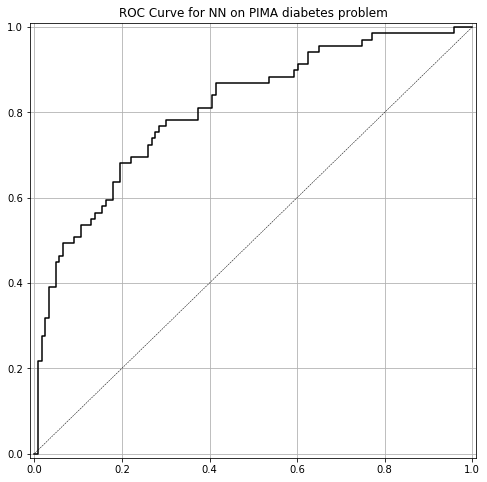

In [27]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

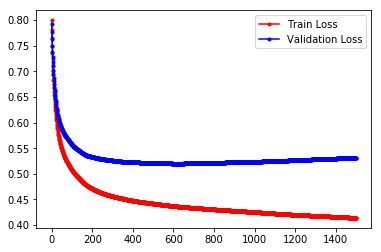

In [28]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()